<a href="https://colab.research.google.com/github/bahrad/Covid/blob/main/Corona_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initialization

Load dependencies

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

import numpy as np
import os
import csv

import pandas as pd
import pickle

from datetime import datetime
from dateutil.parser import parse as dateparse
from collections import Counter
from tqdm.notebook import tqdm
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, QuantileTransformer, OneHotEncoder, LabelBinarizer, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, accuracy_score,classification_report, make_scorer, balanced_accuracy_score, coverage_error, roc_auc_score, confusion_matrix, plot_confusion_matrix, multilabel_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN
from sklearn.utils import class_weight
import sklearn as sk

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline,Pipeline

# !python --version

If using Google colab, mount drive and set location

In [ ]:
from google.colab import drive, files
# drive.mount('/content/drive')

FILELOC = "/content/drive/My Drive/COVID_Python/"

Activate TPU resources if available

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)
    tpu_env=True
except ValueError:
    print('Not connected to a TPU runtime.')
    tpu_env=False

Running on TPU  ['10.127.82.186:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.127.82.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.127.82.186:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


##Initialize Model

Function to define the model.

* "regress" sets the model to output a continuous value from 0 to 1 for regression.
* "singleclass" is for a 0/1 binary output.
* "multiclass" outputs a softmax for a number of classes. The code may be readily modified for multilabel classification as well.
* "output_multiheadatt" generates the attention values for the transformer model, which may be extracted later.
* "use_att" adds a flat sequence-wide attention layer.
* "output_two" allows for two outputs, which maybe jointly used to compute the loss and optimize the model.
* "nclasses" is the number of classes (ignored for regress or singleclass modes
* "mask" allows for masking zeros in the sequence. "numvars" 
* "numvars" if set to a non-zero value adds additional variables as input (such as age/date/gender for clinical severity calculation) which are concatenated after the transformer and/or sequence-wide flat attention layer (if "use_att" is set to True) 

In [ ]:
def reset_model(regress, singleclass, multiclass, output_multiheadatt, use_att, nclasses=4,
                output_two=False, mask=True, numvars = 0):

    if output_multiheadatt:
        model_fn = AttMod_2
    elif output_two:
        model_fn = AttMod_3
    else:
        model_fn = AttModel

    model = model_fn(L=SEQLEN,
                     vocab_size=len(aa_list)+1,
                     embdim = ENCDIM,
                     numheads = NHEADS,
                     ffdim = FFDIM,
                     num_dense = NDENSE,
                     mask_zero = mask,
                     dropout_rate = DROPRATE,
                     trans_drop = TRANSDROPRATE,
                     Nt = NT,
                     W = 1, Nc = NC, Nl = NL,
                     regress=regress,
                     singleclass=singleclass,
                     multiclass=multiclass,
                     use_att=use_att,
                     nclasses=nclasses,
                     nvars=numvars
                     )
    
    optimizer = keras.optimizers.Adam(learning_rate=LEARN_RATE)
    if regress:
        loss = keras.losses.MeanSquaredError()
        metrics = [keras.metrics.MeanSquaredError(name='mse'),
            keras.metrics.MeanSquaredLogarithmicError(name='msle'),
            keras.losses.MeanAbsoluteError(name='mae')
            ]
    if singleclass:
        loss = keras.losses.BinaryCrossentropy()
        metrics = [keras.metrics.BinaryAccuracy(name='acc'),
                   keras.metrics.AUC(name='auc')]
    if multiclass:    
        loss = keras.losses.SparseCategoricalCrossentropy()
        metrics = [keras.metrics.SparseCategoricalAccuracy(name='acc')]

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics,)
                #   steps_per_execution = STEPS_PER_EXECUTION,)

    if output_two:
        losses = {'outfirst':'mean_squared_error',
                  'outpeak':'mean_squared_error'}
        lossweights = {'outfirst':1.0, 'outpeak':1.0}
        metrics = [keras.metrics.MeanSquaredError(name='mse'),
                   keras.metrics.MeanSquaredLogarithmicError(name='msle'),
                   keras.losses.MeanAbsoluteError(name='mae')]
        model.compile(loss=losses, loss_weights=lossweights, optimizer=optimizer,metrics=metrics)

    return model

##Model Parameters

In [ ]:
# These parameters are currently hard-coded
ENCDIM = 1500
NC = 300
NL = 1                  # set to 0 to remove CNN pre-filtering
NT = 1
NHEADS = 8
FFDIM = 64
NDENSE = 64             # set to 0 to deactivate embedding layer
TRANSDROPRATE = 0.4
DROPRATE = 0.0

LEARN_RATE = 0.0001

BATCH_SIZE = 48

STEPS_PER_EXECUTION = 50

##Model Definitions

Transformer and Token & Position Embedding definitions. Adapted from https://keras.io/examples/nlp/text_classification_with_transformer/

In [ ]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="relu"), keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training, mask=None):
        attn_output = self.att(inputs, inputs, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, mask_zero=False):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size,
                                                output_dim=embed_dim,
                                                mask_zero=mask_zero)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,
                                              mask_zero=mask_zero)
        self.mask_zero = mask_zero

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)

        if self.mask_zero:
            mask = x._keras_mask
            return x + positions, mask
        else:
            return x + positions

###Default model definition

In [ ]:
def AttModel(L, vocab_size, embdim, numheads, ffdim, num_dense=False,
             mask_zero=False, dropout_rate=False, trans_drop=0.1,
             Nt=1, W=False, Nc=False, Nl=False,
             regress=True, singleclass=False, multiclass=False, use_att=True,
             nclasses=4, nvars=0):

    inpSeq = keras.Input(shape=(L,))
    if nvars > 0:
        # additional variables besides sequence
        inpVars = keras.Input(shape=(3,))
    x = inpSeq
    if nvars > 0:
        v = inpVars

    if mask_zero:
        x = keras.layers.Masking(mask_value=0)(x)   

    inpSeq = keras.Input(shape=(L,))
    inpVars = keras.Input(shape=(3,))
    x = inpSeq
    v = inpVars

    if mask_zero:
        x, mask = TokenAndPositionEmbedding(L, vocab_size, embdim, mask_zero)(x)
    else:
        x = TokenAndPositionEmbedding(L, vocab_size, embdim, mask_zero)(x)

    if W and Nc and Nl:
        for n in range(Nl):
            x = keras.layers.Conv1D(filters = Nc,
                                kernel_size = W,
                                activation = 'relu',
                                padding = 'same',
                                )(x)
            if n > 1 and n < Nl-1:
                x = keras.layers.BatchNormalization()(x)

    for n in range(Nt):
        x = TransformerBlock(Nc, numheads, ffdim, rate=trans_drop)(x)

    if use_att:
        # Attention layer
        h = keras.layers.TimeDistributed(keras.layers.Dense(Nc, activation='tanh'))(x)
        attention = keras.layers.TimeDistributed(keras.layers.Dense(1, activation='tanh'))(h)
        attention = keras.layers.Flatten()(attention)  
        attention = keras.layers.Softmax(axis=1, name='attention')(attention) # normalize attention values
        attention = keras.layers.RepeatVector(Nc)(attention)
        attention = keras.layers.Permute([2, 1])(attention)
        representation = keras.layers.multiply([h, attention])
        representation = tf.math.reduce_sum(representation, axis = 1)
        x = representation
    else:
        x = keras.layers.GlobalAveragePooling1D()(x)

    if nvars > 0:
        # concatenate additional variables with the transformer output
        h = keras.layers.concatenate([x, v])
    else:
        h = x

    if num_dense:
        x = keras.layers.Dense(num_dense, activation = 'relu')(h)
    if dropout_rate:
        x = keras.layers.Dropout(Params[dropout_rate])(x)

    if regress:
        # finalOut = keras.layers.Dense(1, activation=linear01)(x)
        finalOut = keras.layers.Dense(1, activation='sigmoid')(x)
    if singleclass:
        finalOut = keras.layers.Dense(1, activation='sigmoid')(x)
    if multiclass:
        finalOut = keras.layers.Dense(nclasses, activation='softmax')(x)

    # define the model's start and end points    
    # model = keras.Model(inpTensor, finalOut)
    if nvars > 0:
        model = keras.Model([inpSeq,inpVars], finalOut)
    else:
        model = keras.Model(inpSeq, finalOut)

    return model

###Return multihead attention scores

if "output_multiheadatt" set to True

In [ ]:
def AttMod_2(L, vocab_size, embdim, numheads, ffdim, num_dense=False,
             mask_zero=False, dropout_rate=False, trans_drop=0.1,
             Nt=1, W=False, Nc=False, Nl=False,
             regress=True, singleclass=False, multiclass=False, use_att=True,
             nclasses=4, nvars=0):

    inpSeq = keras.Input(shape=(L,))
    if nvars > 0:
        # additional variables besides sequence
        inpVars = keras.Input(shape=(3,))
    x = inpSeq
    if nvars > 0:
        v = inpVars

    if mask_zero:
        x = keras.layers.Masking(mask_value=0)(x)   

    if mask_zero:
        x, mask = TokenAndPositionEmbedding(L, vocab_size, embdim, mask_zero)(x)
    else:
        x = TokenAndPositionEmbedding(L, vocab_size, embdim, mask_zero)(x)

    if W and Nc and Nl:
        for n in range(Nl):
            x = keras.layers.Conv1D(filters = Nc,
                                kernel_size = W,
                                activation = 'relu',
                                padding = 'same',
                                )(x)
            if n > 1 and n < Nl-1:
                x = keras.layers.BatchNormalization()(x)

    y, attout = keras.layers.MultiHeadAttention(num_heads=numheads, key_dim=Nc,
                                                )(x, x, return_attention_scores=True)
    y = keras.layers.Dropout(trans_drop)(y)
    z = keras.layers.LayerNormalization(epsilon=1e-6)(x + y)
    z1 = keras.Sequential( [keras.layers.Dense(ffdim, activation="relu"), keras.layers.Dense(embdim),])
    z1 = keras.layers.Dropout(trans_drop)(z)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(z + z1)

    if use_att:
        # Attention layer
        h = keras.layers.TimeDistributed(keras.layers.Dense(Nc, activation='tanh'))(x)
        attention = keras.layers.TimeDistributed(keras.layers.Dense(1, activation='tanh'))(h)
        attention = keras.layers.Flatten()(attention)  
        attention = keras.layers.Softmax(axis=1, name='attention')(attention) # normalize attention values
        attention = keras.layers.RepeatVector(Nc)(attention)
        attention = keras.layers.Permute([2, 1])(attention)
        representation = keras.layers.multiply([h, attention])
        representation = tf.math.reduce_sum(representation, axis = 1)
        x = representation
    else:
        x = keras.layers.GlobalAveragePooling1D()(x)

    if nvars > 0:
        # concatenate additional variables with the transformer output
        h = keras.layers.concatenate([x, v])
    else:
        h = x

    if num_dense:
        x = keras.layers.Dense(num_dense, activation = 'relu')(h)
    if dropout_rate:
        x = keras.layers.Dropout(Params[dropout_rate])(x)

    if regress:
        finalOut = keras.layers.Dense(1, activation=linear01)(x)
    if singleclass:
        finalOut = keras.layers.Dense(1, activation='sigmoid')(x)
    if multiclass:
        finalOut = keras.layers.Dense(nclasses, activation='softmax')(x)

    # define the model's start and end points    
    # model = keras.Model(inpTensor, finalOut)
    if nvars > 0:
        model = keras.Model([inpSeq,inpVars], finalOut)
    else:
        model = keras.Model(inpSeq, finalOut)

    return model

###Output two predictions for joint optimization



if "output_two" is set to True

In [ ]:
def AttMod_3(L, vocab_size, embdim, numheads, ffdim, num_dense=False,
             mask_zero=False, dropout_rate=False, trans_drop=0.1,
             Nt=1, W=False, Nc=False, Nl=False,
             regress=True, singleclass=False, multiclass=False, use_att=True,
             nclasses=4, nvars=0):

    inpSeq = keras.Input(shape=(L,))
    if nvars > 0:
        # additional variables besides sequence
        inpVars = keras.Input(shape=(3,))
    x = inpSeq
    if nvars > 0:
        v = inpVars

    if mask_zero:
        x = keras.layers.Masking(mask_value=0)(x)   

    if mask_zero:
        x, mask = TokenAndPositionEmbedding(L, vocab_size, embdim, mask_zero)(x)
    else:
        x = TokenAndPositionEmbedding(L, vocab_size, embdim, mask_zero)(x)

    if W and Nc and Nl:
        for n in range(Nl):
            x = keras.layers.Conv1D(filters = Nc,
                                kernel_size = W,
                                activation = 'relu',
                                padding = 'same',
                                )(x)
            if n > 1 and n < Nl-1:
                x = keras.layers.BatchNormalization()(x)

    for n in range(Nt):
        x = TransformerBlock(Nc, numheads, ffdim, rate=trans_drop)(x)

    if use_att:
        # Attention layer
        h = keras.layers.TimeDistributed(keras.layers.Dense(Nc, activation='tanh'))(x)
        attention = keras.layers.TimeDistributed(keras.layers.Dense(1, activation='tanh'))(h)
        attention = keras.layers.Flatten()(attention)  
        attention = keras.layers.Softmax(axis=1, name='attention')(attention) # normalize attention values
        attention = keras.layers.RepeatVector(Nc)(attention)
        attention = keras.layers.Permute([2, 1])(attention)
        representation = keras.layers.multiply([h, attention])
        representation = tf.math.reduce_sum(representation, axis = 1)
        x = representation
    else:
        x = keras.layers.GlobalAveragePooling1D()(x)

    if nvars > 0:
        # concatenate additional variables with the transformer output
        h = keras.layers.concatenate([x, v])
    else:
        h = x

    if num_dense:
        x = keras.layers.Dense(num_dense, activation = 'relu')(h)
    if dropout_rate:
        x = keras.layers.Dropout(Params[dropout_rate])(x)

    if regress:
        # finalOut = keras.layers.Dense(1, activation=linear01)(x)
        finalOut = keras.layers.Dense(1, activation='sigmoid')(x)
    if singleclass:
        finalOut = keras.layers.Dense(1, activation='sigmoid')(x)
    if multiclass:
        finalOut = keras.layers.Dense(nclasses, activation='softmax')(x)

    out1 = keras.layers.Dense(1, activation='sigmoid', name='outfirst')(x)
    out2 = keras.layers.Dense(1, activation='sigmoid', name='outpeak')(x)
    # define the model's start and end points    
    if nvars > 0:
        model = keras.Model([inpSeq,inpVars], [out1,out2])
    else:
        model = keras.Model(inpSeq, [out1,out2])

    return model

##Function to tokenize sequences

In [ ]:
def tokenize_sequences(data_dataframe, SeqCol='ISM', seqlen=1273):
    def f(x):
        if len(x) < seqlen:
            return x + '*'*(seqlen-len(x))
        elif len(x) > seqlen:
            return x[:seqlen]
        else:
            return x
    data = np.vstack(data_dataframe[SeqCol].apply(f).apply(lambda x: np.array(list(x))))
    aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E',
            'G', 'H', 'I', 'L', 'K', 'M', 'F',
            'P', 'S', 'T', 'W', 'Y', 'V', '-',
            ]
    aa_tokenizer = {aa_list[k]:k+1 for k in range(len(aa_list))}
    aa_tokenizer['*'] = 0
    aa_tokenizer['X'] = 0
    # optionally handle B, J, Z ambiguities
    # Asx	B	Aspartic acid or Asparagine (D or N)
    # Glx	Z	Glutamic acid or Glutamine (E or Q)
    # Xaa	X	Any amino acid
    # Xle	J	Leucine or Isoleucine (L or I)
    aa_tokenizer['B'] = 0
    aa_tokenizer['Z'] = 0
    aa_tokenizer['J'] = 0

    return np.vectorize(aa_tokenizer.get)(data)

aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E',
        'G', 'H', 'I', 'L', 'K', 'M', 'F',
        'P', 'S', 'T', 'W', 'Y', 'V', '-',
        ]

#Dataset Preprocessing

##Corona (Multi-Genus) Sequence Data

Read the csv file with coronavirus sequences (different species)

In [ ]:
data = pd.read_csv(FILELOC + "coronavirus_spike/" + "coronataxonomy_dataset_notpreprocessed.csv")
print(len(data))

# rename column with sequences to "Spike" for consistency with downstream operations
data.rename(columns={'Seq':'Spike'}, inplace=True)

Remove short sequences or those whose species is not coronavirus

In [ ]:
dataset = data[(data.Length>1000) & (data.Species.str.contains('coronavirus'))].copy()

Create labels if classifying for host (human / non-human)

In [ ]:
dataset['hostlabel'] = dataset.Host.apply(lambda x: 1 if x=='Homo sapiens' else 0)

Create labels if classifying by genus

In [ ]:
def f(x):
    if x=='Alphacoronavirus':
        return 0
    if x=='Betacoronavirus':
        return 1
    if x=='Gammacoronavirus':
        return 2
    if x=='Deltacoronavirus':
        return 3

dataset['genuslabel'] = dataset.Genus.apply(f)

Display histogram of sequence lengths and set the maximum sequence length (SEQLEN)

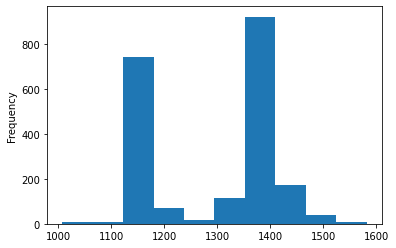

In [ ]:
dataset.Spike.apply(len).plot.hist()

Set sequence length (pad shorter sequences / truncate longer sequences)

In [ ]:
SEQLEN = 1500

Sample dates may indicate that a sample was collected after SARS-CoV-2 is discovered. For some validation (i.e. determining whether SARS-CoV-2 is classified correctly as a Betacoronavirus) may want to remove post Jan 2020 samples. Additional code may be added below to remove those samples.

In [ ]:
dataset['date'] = dataset['Release_Date'].apply(lambda x:dateparse(x))
dataset['date'] = dataset['date'].dt.date

In [ ]:
print(len(dataset[dataset.Collection_Date.isna()])) # some dates may be nandatadf['seqlen'] = datadf.Spike.apply(len)

Tokenize sequences and create training and test data sets

In [ ]:
seqtok = tokenize_sequences(dataset, 'Spike', SEQLEN)

# the code below defines the labels as genus label
# can be modified to define labels as host label, or as both
y = dataset.genus.values

280

In [ ]:
# trainindex = np.random.choice(range(len(seqtok)), size = int(0.8*len(seqtok)), replace=False)
# testindex = np.array([k for k in range(len(seqtok)) if k not in trainindex])

# save train index for future use:
# np.savetxt(FILELOC + 'corona_trainindex.csv', trainindex, fmt='%i', delimiter=',')
trainindex = np.loadtxt(FILELOC + 'corona_trainindex.csv', dtype=int, delimiter=',')

xtrain = seqtok[trainindex]
xtest = seqtok[testindex];
NVARS = 0       # there are no additional variables besides the sequence

ytrain = y[trainindex]
ytest = y[testindex]

##SARS-CoV-2 Lineage Sequence Data

###Raw Sequences (random sample)

Read a file with raw sequences (i.e. not aligned) used to demonstrate lineage prediction. These need to be generated by downloading sequences from GISAID because they cannot be separately distributed.

In [ ]:
# Specific code used to generate a set of raw samples from a pre-existing
# dataframe of sequences, sequence IDs, and date of first collection

# with open(FILELOC + 'spike_reldate_0303.pkl', 'rb') as f:
#     df = pickle.load(f)
# df.reset_index(drop=False, inplace=True)
# df = df[df.Lineage!="None"].reset_index(drop=True)
# df_sample = pd.concat([df[df.Count >= 100].sample(4000), df[df.Count.between(10,99)].sample(12000),
#                        df[df.Count.between(2,3)].sample(3000), df[df.Count==1].sample(1000)], axis=0)
# with open(f'{FILELOC}coronavirus_spike_sars2cov_rawsample.pkl', 'wb') as f:
#     pickle.dump(df_sample, f)

with open(f'{FILELOC}coronavirus_spike_sars2cov_rawsample.pkl', 'rb') as f:
    datadf = pickle.load(f)
datadf.reset_index(drop=False, inplace=True)

Assign lineages to labels (this can be readily modified)

In [ ]:
SEQLEN = 1500   # set sequence length (pad shorter sequences / truncate longer sequences)

labelmap = {'AY.4':0, 'B.1.617.2':0,
            'B.1':1, 'B.1.177':1, 'B.1.1':1, 'B.1.2':1,
            'BA.1':2,
            'BA.1.1':3,
            'BA.2':4,
            'P.1':5,
            'B.1.351':6,
            'B.1.427':7, 'B.1.429':7,
            }

datadf['Label'] = datadf['Lineage'].map(labelmap)
datadf = datadf[datadf.Label.notna()].reset_index(drop=True)
datadf['Label'] = datadf['Label'].astype(int)

Tokenize sequences and create training and test data sets

In [ ]:
seqtok = tokenize_sequences(dataset, 'Spike', SEQLEN)

# the code below defines the labels as genus label
# can be modified to define labels as host label, or as both
y = dataset.genus.values

280

In [ ]:
# trainindex = np.random.choice(range(len(seqtok)), size = int(0.8*len(seqtok)), replace=False)
# testindex = np.array([k for k in range(len(seqtok)) if k not in trainindex])

# save train index for future use:
# np.savetxt(FILELOC + 'corona_trainindex.csv', trainindex, fmt='%i', delimiter=',')
trainindex = np.loadtxt(FILELOC + 'corona_trainindex.csv', dtype=int, delimiter=',')

xtrain = seqtok[trainindex]
xtest = seqtok[testindex];
NVARS = 0       # there are no additional variables besides the sequence

ytrain = y[trainindex]
ytest = y[testindex]

###Aligned Sequences (covid-patient dataset)

Read a file with aligned SARS-CoV-2 sequences to predict lineage or date of first occurrence. In this case, the data were originally generated for clinical severity prediction, and are then processed to generate distinct sequences (i.e. remove repeated sequences from the database) and assign them a date of first occurence and lineage.

In [ ]:
# seqs = pd.read_csv(FILELOC + 'covid_patient_seqs_20220228/covid_patient_seqs_20220228.csv')
# seqs.drop(columns="Spike", inplace=True)

# df = seqs.copy()
# df['Country'] = df['Location'].apply(lambda x: x.split('/')[1].strip())
# REFDATE = '2019-12-01'; refdt = dateparse(REFDATE)
# def f(x):
#     return (dateparse(x) - refdt).days
# df['Date'] = df['Collection date'].apply(f)
# df = df[['SequenceID', 'Date', 'Clade', 'Lineage', 'Country', 'MaskedSeq', 'Collection date', 'Location']]

# df = df[df.Date > 0] # get rid of negative date values

# df_reldate = df.groupby("MaskedSeq")["Date"].apply(list).to_frame()
# df_reldate['First_Date'] = df_reldate.Date.apply(np.amin)
# df_reldate['Last_Date'] = df_reldate.Date.apply(np.amax)
# df_reldate['Peak_Date'] = df_reldate.Date.apply(lambda x: np.median(np.argwhere(np.bincount(x)==np.amax(np.bincount(x)))))
# df_reldate['Count'] = df_reldate.Date.apply(len)
# max_first_date = max(df_reldate.First_Date)
# df_reldate['relfirstdate'] = df_reldate['First_Date'].apply(lambda x: x/max_first_date)
# df_out = df_reldate.join(df.groupby("MaskedSeq")["Location"].apply(list).to_frame())
# def f(x):
#     try:
#         return pd.Series.mode(x)[0]
#     except:
#         return np.nan

# df_out = df_out.join(df.groupby("MaskedSeq")["Clade"].agg(f).to_frame())
# df_out = df_out.join(df.groupby("MaskedSeq")["Lineage"].agg(f).to_frame())

# with open(FILELOC + 'covid_patient_seqs_20220228/covid_patient_seqs_grouped_20220228.pkl', 'wb') as f:
#     pickle.dump(df_out, f)

with open(FILELOC + 'covid_patient_seqs_20220228/covid_patient_seqs_grouped_20220228.pkl', 'rb') as f:
    datadf = pickle.load(f)
datadf.reset_index(drop=True, inplace=True)

The following is used to assign labels based on lineage.

In [ ]:
# rename column with sequences to "Spike" for consistency with downstream operations
datadf.rename(columns={'MaskedSeq':'Spike'}, inplace=True)

datadf = datadf[datadf.Count >= 2].reset_index(drop=True)

labelmap = {'AY.4':0, 'B.1.617.2':0,
            'B.1':1, 'B.1.177':1, 'B.1.1':1, 'B.1.2':1,
            'BA.1':2,
            'BA.1.1':3,
            'BA.2':4,
            'P.1':5,
            'B.1.351':6,
            'B.1.427':7, 'B.1.429':7,
            }

datadf['Label'] = datadf['Lineage'].map(labelmap)
datadf = datadf[datadf.Label.notna()].reset_index(drop=True)
datadf['Label'] = datadf['Label'].astype(int)

# aligned sequence lengths are equally 1273
SEQLEN = 1273

Tokenize sequences and create training and test data sets

In [ ]:
seqtok = tokenize_sequences(dataset, 'Spike', SEQLEN)

# the code below defines the labels as genus label
# can be modified to define labels as host label, or as both
y = dataset.genus.values

280

In [ ]:
# trainindex = np.random.choice(range(len(seqtok)), size = int(0.8*len(seqtok)), replace=False)
# testindex = np.array([k for k in range(len(seqtok)) if k not in trainindex])

# save train index for future use:
# np.savetxt(FILELOC + 'corona_trainindex.csv', trainindex, fmt='%i', delimiter=',')
trainindex = np.loadtxt(FILELOC + 'corona_trainindex.csv', dtype=int, delimiter=',')

xtrain = seqtok[trainindex]
xtest = seqtok[testindex];
NVARS = 0       # there are no additional variables besides the sequence

ytrain = y[trainindex]
ytest = y[testindex]

###COVID-19 Disease Severity Data

Use a file of sequences pre-processed as per other scripts

In [ ]:
pdf = pd.read_csv(FILELOC + 'covid_patient_seqs_20220228/covid_patient_seqs_20220228.csv')

print(len(pdf))

352003


Use the following code to generate/regenerate labels (commented out because the csv file loaded above already has labels).

In [ ]:
# labelmap = {'alive' : -1,
#             'asymptomatic' : 0,
#             'dead' : 1,
#             'hospitalized' : 1,
#             'mild' : 0,
#             'moderate' : 0,
#             'released' : 1,
#             'screening' : 0,
#             'severe' : 1,
#             'symptomatic' : -1,
#             'unknown' : -1,
#         }

# pdf['Label'] = pdf['Category'].map(labelmap).astype(int)

Remove samples with invalid labels and patient variables (which were set to -1 in preprocessing).

In [ ]:
pdf.drop(pdf[pdf.Label==-1].index, inplace=True)
print(len(pdf))
pdf.drop(pdf[pdf.Age==-1].index, inplace=True)
print(len(pdf))
pdf.drop(pdf[pdf.Gender==-1].index, inplace=True)
print(len(pdf))
pdf.reset_index(drop=True, inplace=True)

pdf.drop(columns = 'Spike', inplace=True)

# rename column with sequences to "Spike" for consistency with downstream operations
pdf.rename(columns={'MaskedSeq':'Spike'}, inplace=True)
# aligned sequence lengths are equally 1273
SEQLEN = 1273

147661
143221
140154


Define patient variables (age/gender/date of sample collection)

In [ ]:
vars = pdf[['Age','Gender','reldate']].values
# "reldate" is the sample collection date in days after December 1, 2019

NVARS = 3
NCLASSES = 2    # 2 outcomes (mild/severe)

Tokenize sequence and create training and testing data

In [ ]:
seqtok = tokenize_sequences(pdf, 'Spike', SEQLEN)
y = pdf.Label.values

In [ ]:
# trainindex = np.random.choice(range(len(seqtok)), size = int(0.7*len(seqtok)), replace=False)
# testindex = np.array([k for k in range(len(seqtok)) if k not in trainindex])

# save train index for future use:
# np.savetxt(FILELOC + 'covidpatient_trainindex.csv', trainindex, fmt='%i', delimiter=',')

# load predefined set of training indices
trainindex = np.loadtxt(FILELOC + 'covidpatient_trainindex.csv', dtype=int, delimiter=',')

xtrain = [seqtok[trainindex], vars[trainindex]]
xtest = [seqtok[testindex], vars[testindex]]
ytrain = y[trainindex]
ytest = y[testindex]

Use a preexisting file of patient data and sequences that has already been processed as above

In [ ]:
# The file loaded below already has training and test sets defined

with open (FILELOC + 'covid_patient_seqs_20220228/covid_patient_data_old.pkl', 'rb') as f:
    traindf, testdf = pickle.load(f)
print(len(traindf), len(testdf))

# rename column with sequences to "Spike" for consistency
traindf.rename(columns={'ISM':'Spike'}, inplace=True)
testdf.rename(columns={'ISM':'Spike'}, inplace=True)

NVARS = 3       # 3 patient variables (age/gender/date)
NCLASSES = 2    # 2 outcomes (mild/severe)

trainvars = traindf[['age', 'gender', 'date']].values
testvars = testdf[['age', 'gender', 'date']].values

SEQLEN = 1273

44003 21913


Tokenize sequences and define "xtrain/xtest/ytrain/ytest" consistently with other methods for use in training and validation below.

In [ ]:
trainseq = tokenize_sequences(traindf, 'Spike', SEQLEN)
testseq = tokenize_sequences(testdf, 'Spike', SEQLEN)

xtrain = [trainseq, trainvars]
xtest = [testseq, testvars]
ytrain = traindf.Label.values
ytest = testdf.Label.values

#Model Training and Evaluation

##Class Balancing

In [ ]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight(class_weight='balanced',
                                                       classes=np.arange(NCLASSES), y=ytrain))

# optionally, each sample may be weighted individually
sample_weights = np.array([class_weights[int(yi)] for yi in ytrain])
print(class_weights)

[1.1281663419136498, 0.8979837557650708]


##Train Model

This training routine operates in one shot with a preset number of epochs. Early stopping is optional.

In [ ]:
NUM_EPOCHS = 100
# A larger batch size more optimally uses TPU resources
BATCH_SIZE = 48*8 # 48*4
# VAL_SPLIT = 0.2   # use if defining early stopping callbacks with validation data

# See Tensorflow documentation for how to modify the early stopping callback

# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor = 'loss',
#     verbose = 1,
#     patience = 10, #5,
#     mode = 'auto',
#     min_delta = 0,
#     restore_best_weights = True
#     )

tf.keras.backend.clear_session()
if tpu_env:
    with tpu_strategy.scope():
        model = reset_model(regress=False, singleclass=True, multiclass=False,
                            output_multiheadatt=True, use_att=True, nclasses=NCLASSES,
                            output_two=False, numvars=3, mask=True)
else:
    model = reset_model(regress=False, singleclass=False, multiclass=True,
                        output_multiheadatt=False, use_att=True, nclasses=NCLASSES,
                        numvars=NVARS, mask=False)
    
# Output table of deep model layers and parameters / connections
model.summary()

history = model.fit(xtrain, ytrain,
                    # sample_weight = sample_weights,
                    # use the following instead of sample_weight if weighting samples individually
                    class_weight = {c:class_weights[c] for c in range(NCLASSES)},
                    batch_size = BATCH_SIZE,
                    epochs = NUM_EPOCHS,
                    verbose = 1,
                    # validation_split = VAL_SPLIT,
                    # callbacks = [early_stopping],
                    )

model.save_weights(f"{FILELOC}weights_sarscov2_20220408.h5", save_format='h5', overwrite=True)

# to save weights of the model
# model.save_weights(f"{FILELOC}taxonomy_weights.h5", save_format='h5', overwrite=True)
# np.savetxt(FILELOC + 'corona_trainindex_sars2cov_20220331.csv', trainindex, fmt='%i', delimiter=',')
# model.save_weights(f"{FILELOC}weights_sarscov2_20220331.h5", save_format='h5', overwrite=True)
# model.save_weights(f"{FILELOC}weights_sarscov2_20220331_nodense.h5", save_format='h5', overwrite=True)

Output confusion matrix and sklearn classification report (precision, recall, f1-score)

In [ ]:
print("Results for Testing Data:")
test_predict = model.predict(xtest)
test_predict_bool = np.round(test_predict)
ClassRep = classification_report(ytest, test_predict_bool.argmax(axis=1))
ConfMatrix = confusion_matrix(ytest, test_predict_bool.argmax(axis=1))
# ConfMatrix = multilabel_confusion_matrix(ytest, test_predict_bool)
print(ClassRep)
print(ConfMatrix)

##Load Pretrained Model

The arguments for reset_model() should be the same as used for model training.

In [ ]:
tf.keras.backend.clear_session()
if tpu_env:
    with tpu_strategy.scope():
        model= reset_model(regress=False, singleclass=False, multiclass=True,
                        output_multiheadatt=False, use_att=True, nclasses=4)
        model.load_weights(f"{FILELOC}taxonomy_weights_20220112_seq1000_{run}.h5")
        model.compile()
else:
    model= reset_model(regress=False, singleclass=False, multiclass=True,
                    output_multiheadatt=False, use_att=True, nclasses=4)
    model.load_weights(f"{FILELOC}taxonomy_weights_20220112_seq1000_{run}.h5")
    model.compile()

In [ ]:
# Load evaluation data and tokenize sequences

# Use Dataset Proeprocessing section of notebook to define an appropriate
# set of evaluation data, i.e., a dataframe with the name "tdf"

tok = tokenize_sequences(tdf, 'Spike', SEQLEN)

The sample code below generates embedding data, attention data, and predictions and loads them in a dataframe with evaluation data

In [ ]:
tok = tokenize_sequences(tdf,'MaskedSeq',1500)

with tpu_strategy.scope():
    get_embedding_model = keras.Model(inputs=model.input,outputs=model.get_layer('dense_4').output)
    get_embedding_model.compile()
    get_attention_model = keras.Model(inputs=model.input,outputs=model.get_layer('attention').output)
    get_attention_model.compile()
    pred = model.predict(tok)
    emb = get_embedding_model.predict(tok)
    att = get_attention_model.predict(tok)
    tdf['pred'] = [p for p in pred]
    tdf['emb'] = [e for e in emb]
    tdf['att'] = [a for a in att]

###Plot Attention

Sample code to plot attention

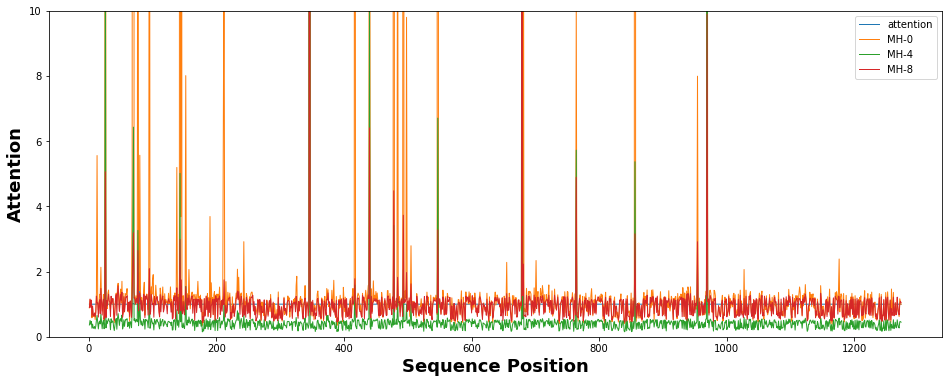

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(16,6)

# att_plot = np.median(att,axis=0)
# ax.plot(range(1,SEQLEN+1), att_plot, linewidth=1, color='black')

att_plot = att[565,:]/np.median(att[565,:])
ax.plot(range(1,SEQLEN+1), att_plot, linewidth=1, label='attention')
att_plot = mha[0]/np.median(mha[0])
ax.plot(range(1,SEQLEN+1), att_plot, linewidth=1, label='MH-0')
att_plot = mha[4]/np.median(mha[7])
ax.plot(range(1,SEQLEN+1), att_plot, linewidth=1, label='MH-4')
att_plot = mha[7]/np.median(mha[7])
ax.plot(range(1,SEQLEN+1), att_plot, linewidth=1, label='MH-8')

plt.ylim(0,10)

# for k in [0,1000,11000]:
#     ax.plot(range(1,SEQLEN+1), att[k], linewidth=1, label=k)

ax.set_xlabel('Sequence Position', fontsize=18, fontweight='bold')
ax.set_ylabel('Attention', fontsize=18, fontweight='bold')

plt.legend()
plt.show()

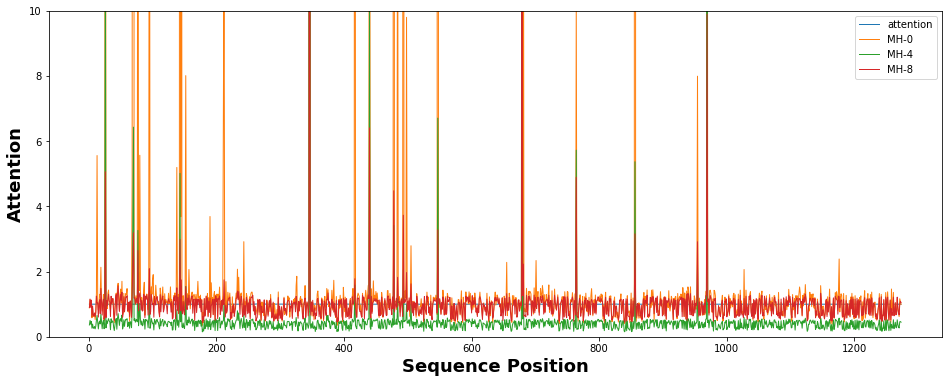

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(16,6)

# att_plot = np.median(att,axis=0)
# ax.plot(range(1,SEQLEN+1), att_plot, linewidth=1, color='black')

att_plot = att[565,:]/np.median(att[565,:])
ax.plot(range(1,SEQLEN+1), att_plot, linewidth=1, label='attention')
att_plot = mha[0]/np.median(mha[0])
ax.plot(range(1,SEQLEN+1), att_plot, linewidth=1, label='MH-0')
att_plot = mha[4]/np.median(mha[7])
ax.plot(range(1,SEQLEN+1), att_plot, linewidth=1, label='MH-4')
att_plot = mha[7]/np.median(mha[7])
ax.plot(range(1,SEQLEN+1), att_plot, linewidth=1, label='MH-8')

plt.ylim(0,10)

# for k in [0,1000,11000]:
#     ax.plot(range(1,SEQLEN+1), att[k], linewidth=1, label=k)

ax.set_xlabel('Sequence Position', fontsize=18, fontweight='bold')
ax.set_ylabel('Attention', fontsize=18, fontweight='bold')

plt.legend()
plt.show()

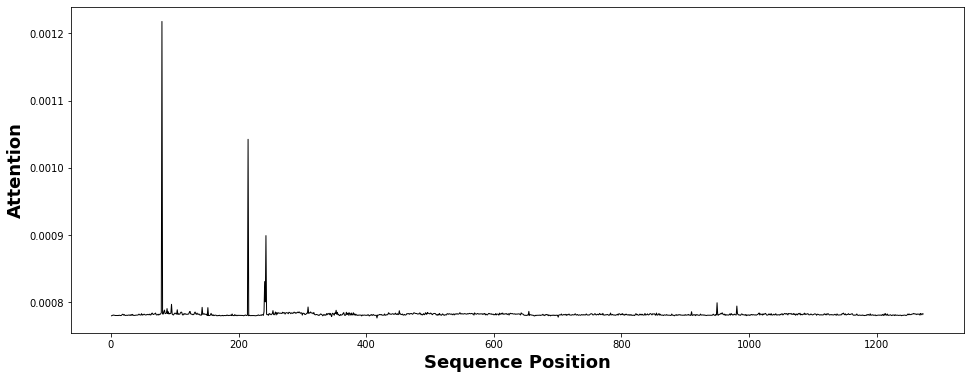

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(16,6)

att_plot = np.median(att,axis=0)
ax.plot(range(1,SEQLEN+1), att_plot, linewidth=1, color='black')

ax.set_xlabel('Sequence Position', fontsize=18, fontweight='bold')
ax.set_ylabel('Attention', fontsize=18, fontweight='bold')

plt.show()

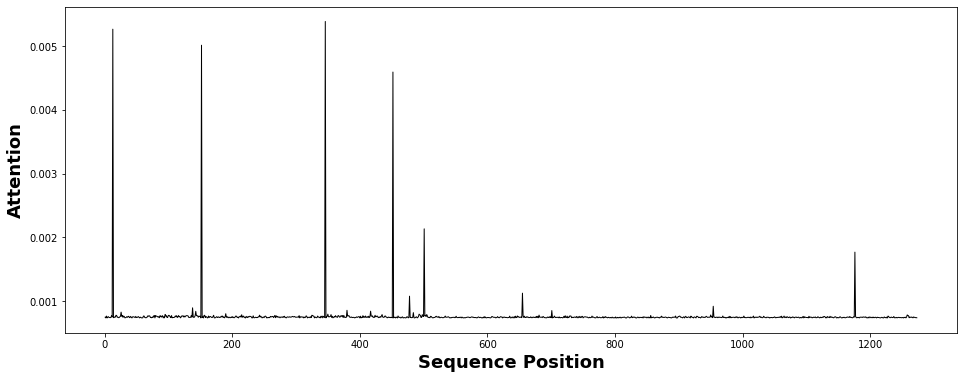

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(16,6)

att_plot = np.median(att,axis=0)
ax.plot(range(1,SEQLEN+1), att_plot, linewidth=1, color='black')

ax.set_xlabel('Sequence Position', fontsize=18, fontweight='bold')
ax.set_ylabel('Attention', fontsize=18, fontweight='bold')

plt.show()

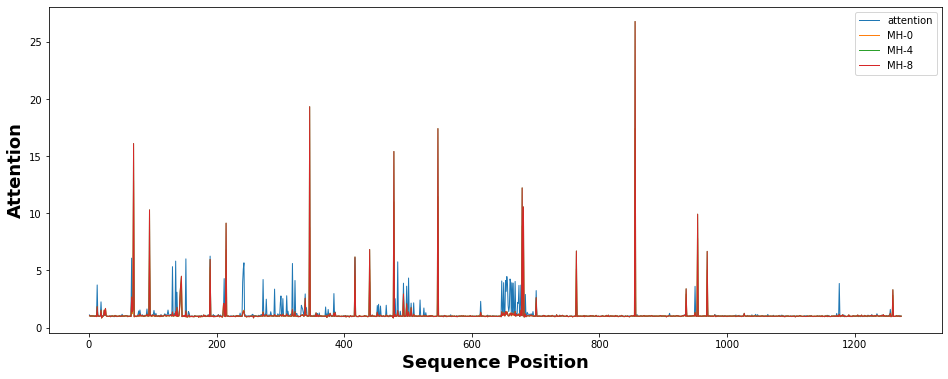

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(16,6)

# att_plot = np.median(att,axis=0)
# ax.plot(range(1,SEQLEN+1), att_plot, linewidth=1, color='black')

att_plot = att[565,:]/np.median(att[565,:])
ax.plot(range(1,SEQLEN+1), att_plot, linewidth=1, label='attention')
att_plot = mha[0]/np.median(mha[0])
ax.plot(range(1,SEQLEN+1), att_plot, linewidth=1, label='MH-0')
att_plot = mha[4]/np.median(mha[7])
ax.plot(range(1,SEQLEN+1), att_plot, linewidth=1, label='MH-4')
att_plot = mha[7]/np.median(mha[7])
ax.plot(range(1,SEQLEN+1), att_plot, linewidth=1, label='MH-8')

# for k in [0,1000,11000]:
#     ax.plot(range(1,SEQLEN+1), att[k], linewidth=1, label=k)

ax.set_xlabel('Sequence Position', fontsize=18, fontweight='bold')
ax.set_ylabel('Attention', fontsize=18, fontweight='bold')

plt.legend()
plt.show()

In [ ]:
b
np.where(att_plot > 0.0009)[0]

array([  12,   18,   66,   68,   69,   77,   79,   90,   94,  101,  123,
        130,  135,  137,  141,  142,  143,  144,  151,  155,  189,  210,
        211,  240,  241,  242,  272,  277,  284,  290,  299,  300,  303,
        309,  311,  318,  322,  332,  333,  334,  337,  338,  340,  370,
        374,  383,  385,  416,  439,  451,  453,  456,  465,  477,  479,
        483,  487,  492,  497,  500,  504,  508,  518,  524,  546,  613,
        646,  647,  649,  652,  653,  654,  655,  656,  657,  658,  659,
        660,  662,  664,  666,  667,  671,  672,  673,  676,  677,  678,
        679,  680,  683,  695,  700,  763,  855,  935,  949,  953,  968,
       1175, 1255, 1259])

In [ ]:
sdf = pd.read_csv(FILELOC + "species_dataset_20211127.csv")

In [ ]:
run = 1
tf.keras.backend.clear_session()
with tpu_strategy.scope():
    model= reset_model(regress=False, singleclass=False, multiclass=True,
                    output_multiheadatt=False, use_att=True, nclasses=4)
    model.load_weights(f"{FILELOC}taxonomy_weights_20220112_seq1000_{run}.h5")
    model.compile()

In [ ]:
tok = tokenize_sequences(sdf,'Seq',1500)

with tpu_strategy.scope():
    get_embedding_model = keras.Model(inputs=model.input,outputs=model.get_layer('dense_4').output)
    get_embedding_model.compile()
    get_attention_model = keras.Model(inputs=model.input,outputs=model.get_layer('attention').output)
    get_attention_model.compile()
    pred = model.predict(tok)
    emb = get_embedding_model.predict(tok)
    att = get_attention_model.predict(tok)
    sdf['pred'] = [p for p in pred]
    sdf['emb'] = [e for e in emb]
    sdf['att'] = [a for a in att]

Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


In [ ]:
# with open(FILELOC + 'topsequences_taxonomy_20220112.pkl', 'wb') as f:
#     pickle.dump(tdf, f)
# with open(FILELOC + 'topsequences_taxonomy_20220112.pkl', 'rb') as f:
#     tdf = pickle.load(f)

# with open(FILELOC + 'topsequences_taxonomy_20220112_seq1000.pkl', 'wb') as f:
#     pickle.dump(tdf, f)
with open(FILELOC + 'topsequences_taxonomy_20220112_seq1000.pkl', 'rb') as f:
    tdf = pickle.load(f)

# with open(FILELOC + 'allsequences_taxonomy_20220112_seq1000.pkl', 'wb') as f:
    # pickle.dump(sdf, f)
with open(FILELOC + 'allsequences_taxonomy_20220112_seq1000.pkl', 'rb') as f:
    sdf = pickle.load(f)

In [ ]:
 from collections import Counter

# error = {}
# for run in range(1,11):
for run in [9]:
    error[run] = {}

    tf.keras.backend.clear_session()
    with tpu_strategy.scope():
        model= reset_model(regress=False, singleclass=False, multiclass=True,
                        output_multiheadatt=False, use_att=True, nclasses=4)
        # model.load_weights(f"{FILELOC}taxonomy_weights_20211213_{run}.h5")
        model.load_weights(f"{FILELOC}taxonomy_weights_20211221_{run}.h5")        
        model.compile()

        vdf = pd.read_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_valid1001_raw_sequences.csv')
        vdf.drop(columns='sample_weight',inplace=True)
        valtok = tokenize_sequences(vdf, SeqCol='ISM', seqlen=1500)
        pred = model.predict(valtok, verbose=1, batch_size=96)
        vdf['Predict_Genus'] = pred.argmax(axis=1)
        error[run]["Patient Validation Data"] = [Counter(vdf.Predict_Genus)[1] / len(vdf), len(vdf), Counter(vdf.Predict_Genus)]

        vdf = pd.read_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_raw_sequences.csv')
        vdf.drop(columns='sample_weight',inplace=True)
        valtok = tokenize_sequences(vdf, SeqCol='ISM', seqlen=1500)
        pred = model.predict(valtok, verbose=1, batch_size=96)
        vdf['Predict_Genus'] = pred.argmax(axis=1)
        error[run]["Patient Training Data"] = [Counter(vdf.Predict_Genus)[1] / len(vdf), len(vdf), Counter(vdf.Predict_Genus)]

        vdf = rawsample
        valtok = tokenize_sequences(vdf, 'Spike', seqlen=1500)
        pred = model.predict(valtok, verbose=1, batch_size=96)
        vdf['Predict_Genus'] = pred.argmax(axis=1)
        error[run]["Raw Sample"] = [Counter(vdf.Predict_Genus)[1] / len(vdf), len(vdf), Counter(vdf.Predict_Genus)]

        vdf = rawshort
        valtok = tokenize_sequences(vdf, 'Spike', seqlen=1500)
        pred = model.predict(valtok, verbose=1, batch_size=96)
        vdf['Predict_Genus'] = pred.argmax(axis=1)
        error[run]["Raw Short Sequences"] = [Counter(vdf.Predict_Genus)[1] / len(vdf), len(vdf), Counter(vdf.Predict_Genus)]

        vdf = rawnoise
        valtok = tokenize_sequences(vdf, 'Spike', seqlen=1500)
        pred = model.predict(valtok, verbose=1, batch_size=96)
        vdf['Predict_Genus'] = pred.argmax(axis=1)
        error[run]["Raw Noisy Sequences"] = [Counter(vdf.Predict_Genus)[1] / len(vdf), len(vdf), Counter(vdf.Predict_Genus)] 

datatypes = list(error[1].keys())
mean_error = {d:np.mean([error[k][d][0] for k in range(1,11)]) for d in datatypes}
std_error = {d:np.std([error[k][d][0] for k in range(1,11)]) for d in datatypes}

print("Dataset   |    Error    |    Dataset size")
for run in range(1,11):
    print(f"Run {run}")
    for e,v in error[run].items():
        print(f"{e}  |  {v[0]}  |  {v[1]}")

382/382 [==============================] - 18s 46ms/step
Dataset   |    Error    |    Dataset size
Run 1
Patient Validation Data  |  0.9401432380155784  |  19129
Patient Training Data  |  0.9667774086378738  |  903
Raw Sample  |  0.97937  |  100000
Raw Short Sequences  |  0.433431744692816  |  14226
Raw Noisy Sequences  |  0.8557429850420352  |  36636
Run 2
Patient Validation Data  |  0.9447958596894767  |  19129
Patient Training Data  |  0.9656699889258029  |  903
Raw Sample  |  0.98395  |  100000
Raw Short Sequences  |  0.4519893153381133  |  14226
Raw Noisy Sequences  |  0.9232721912872585  |  36636
Run 3
Patient Validation Data  |  0.9461027758900099  |  19129
Patient Training Data  |  0.9656699889258029  |  903
Raw Sample  |  0.9857  |  100000
Raw Short Sequences  |  0.4673836637143259  |  14226
Raw Noisy Sequences  |  0.9331258871055792  |  36636
Run 4
Patient Validation Data  |  0.9485597783470124  |  19129
Patient Training Data  |  0.9667774086378738  |  903
Raw Sample  |  0.98

In [ ]:
with open(FILELOC + "covid_taxonomy_error_trans_20211221.pkl", "wb") as f:
    pickle.dump([error, datatypes, mean_error, std_error], f)
# with open(FILELOC + "covid_taxonomy_error_trans.pkl", "wb") as f:
#     pickle.dump([error, datatypes, mean_error, std_error], f)
# with open(FILELOC + "covid_taxonomy_error_trans.pkl", "rb") as f:
#     error, datatypes, mean_error, std_error = pickle.load(f)

In [ ]:
for r in error:
    print(r, error[r]['Raw Short Sequences'])

1 [0.433431744692816, 14226, Counter({2: 8056, 1: 6166, 0: 4})]
2 [0.4519893153381133, 14226, Counter({2: 7699, 1: 6430, 0: 97})]
3 [0.4673836637143259, 14226, Counter({2: 7376, 1: 6649, 0: 201})]
4 [0.4826374244341347, 14226, Counter({2: 7261, 1: 6866, 0: 99})]
5 [0.5074511457893996, 14226, Counter({1: 7219, 2: 6795, 0: 212})]
6 [0.49205679741318714, 14226, Counter({1: 7000, 2: 6971, 0: 255})]
7 [0.5024602839870659, 14226, Counter({1: 7148, 2: 6940, 0: 138})]
8 [0.5270631238577252, 14226, Counter({1: 7498, 2: 6590, 0: 138})]
9 [0.4566990018276395, 14226, Counter({2: 7493, 1: 6497, 0: 236})]
10 [0.4518487276817095, 14226, Counter({2: 7288, 1: 6428, 0: 510})]


In [ ]:
std_error

{'Patient Training Data': 0.0005537098560354226,
 'Patient Validation Data': 0.002687528187889592,
 'Raw Noisy Sequences': 0.03778744888055464,
 'Raw Sample': 0.0028185095351976473,
 'Raw Short Sequences': 0.02828481535845419}

In [ ]:
with open(f'{FILELOC}coronovirus_spike_taxonomy_sequence_samples.pkl', 'rb') as f:
    rawsample, rawshort, rawnoise = pickle.load(f)
pat_val = pd.read_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_valid1001_raw_sequences.csv')
pat_train = pd.read_csv(FILELOC + 'covid_rawseqs_crossval/covid_patient_0912_raw_sequences.csv')

In [ ]:
run = 8

tf.keras.backend.clear_session()
with tpu_strategy.scope():
    model= reset_model(regress=False, singleclass=False, multiclass=True,
                    output_multiheadatt=False, use_att=True, nclasses=4)
    # model.load_weights(f"{FILELOC}taxonomy_weights_20211213_{run}.h5")
    model.load_weights(f"{FILELOC}taxonomy_weights_20211221_{run}.h5")
    model.compile()

datatype = ['Patient Training Data', 'Patient Validation Data',
            'Raw Noisy Sequences', 'Raw Sample', 'Raw Short Sequences']
datasrc = [pat_train, pat_val, rawnoise, rawsample, rawshort]

In [ ]:
pred = {}; emb = {}; att = {}
with tpu_strategy.scope():
    get_embedding_model = keras.Model(inputs=model.input,outputs=model.get_layer('dense_4').output)
    get_embedding_model.compile()
    get_attention_model = keras.Model(inputs=model.input,outputs=model.get_layer('attention').output)
    get_attention_model.compile()
    for d in range(len(datatype)):
        if 'Patient' in datatype[d]:
            tok = tokenize_sequences(datasrc[d], 'ISM', seqlen=1500)
        else:
            tok = tokenize_sequences(datasrc[d], 'Spike', seqlen=1500)
        pred[datatype[d]] = model.predict(tok, verbose=True, batch_size=32*8)
        emb[datatype[d]] = get_embedding_model.predict(tok, verbose=True, batch_size=32*8)
        att[datatype[d]] = get_attention_model.predict(tok, verbose=True, batch_size=32*8)

with open(FILELOC + 'covid_taxonomy_model_results_20211221.pkl', 'wb') as f:
    pickle.dump([datatype, pred, emb, att], f)

56/56 [==============================] - 11s 199ms/step


In [ ]:
# mha = {}
# for h in range(8):
#     mha[h] = np.sum(wts[0,h], axis=1)
# mhadf = pd.DataFrame.from_dict({f'Head {h}':mha[h] for h in range(8)})
# topdf = pd.DataFrame.from_dict({f'Head {h}':mhadf.sort_values(by=f'Head {h}', ascending=False).head(20).index for h in range(8)})
# display(topdf)

In [ ]:
mha = {}
for h in range(8):
    mha[h] = np.sum(wts[0,h], axis=0)
mhadf = pd.DataFrame.from_dict({f'Head {h}':mha[h] for h in range(8)})
topdf = pd.DataFrame.from_dict({f'Head {h}':mhadf.sort_values(by=f'Head {h}', ascending=False).head(20).index for h in range(8)})
display(topdf)

,Head 0,Head 1,Head 2,Head 3,Head 4,Head 5,Head 6,Head 7
0,546,345,345,345,345,345,345,345
1,855,678,678,678,678,678,678,678
2,345,968,968,968,968,968,968,968
3,69,477,439,439,25,439,439,439
4,477,439,763,763,439,763,763,25
5,142,546,25,477,546,25,477,763
6,68,855,477,546,69,477,25,477
7,492,763,69,855,763,492,546,492
8,416,492,546,25,855,546,855,546
9,144,25,855,69,142,855,69,69


###Plot Multi-Head Attention

Sample code to plot and extract attention from transformer heads

In [ ]:
get_mha_model = keras.Model(inputs=model.input,outputs=model.get_layer('multi_head_attention').output)

In [ ]:
labelmap

{'AY.4': 0,
 'B.1': 1,
 'B.1.1': 1,
 'B.1.177': 1,
 'B.1.2': 1,
 'B.1.351': 6,
 'B.1.427': 7,
 'B.1.429': 7,
 'B.1.617.2': 0,
 'BA.1': 2,
 'BA.1.1': 3,
 'BA.2': 4,
 'P.1': 5}

In [ ]:
np.where(ytest==0)

(array([  3,  12,  17,  18,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  42, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
        115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
        167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
        180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
        193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
        219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
        232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
        245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,
        258, 259, 260, 261, 262, 263, 264, 265, 266

In [ ]:
model.predict(xtest[197,:].reshape(1,-1))

array([[9.9765670e-01, 2.0364139e-03, 2.4277039e-04, 9.8151725e-07,
        4.2033906e-05, 9.5756732e-06, 6.7961717e-12, 1.1495328e-05]],
      dtype=float32)

In [ ]:
output,wts = get_mha_model.predict(xtest[565,:].reshape(1,-1))

In [ ]:
np.shape(wts)

(1, 8, 1273, 1273)

In [ ]:
from matplotlib.colors import LogNorm

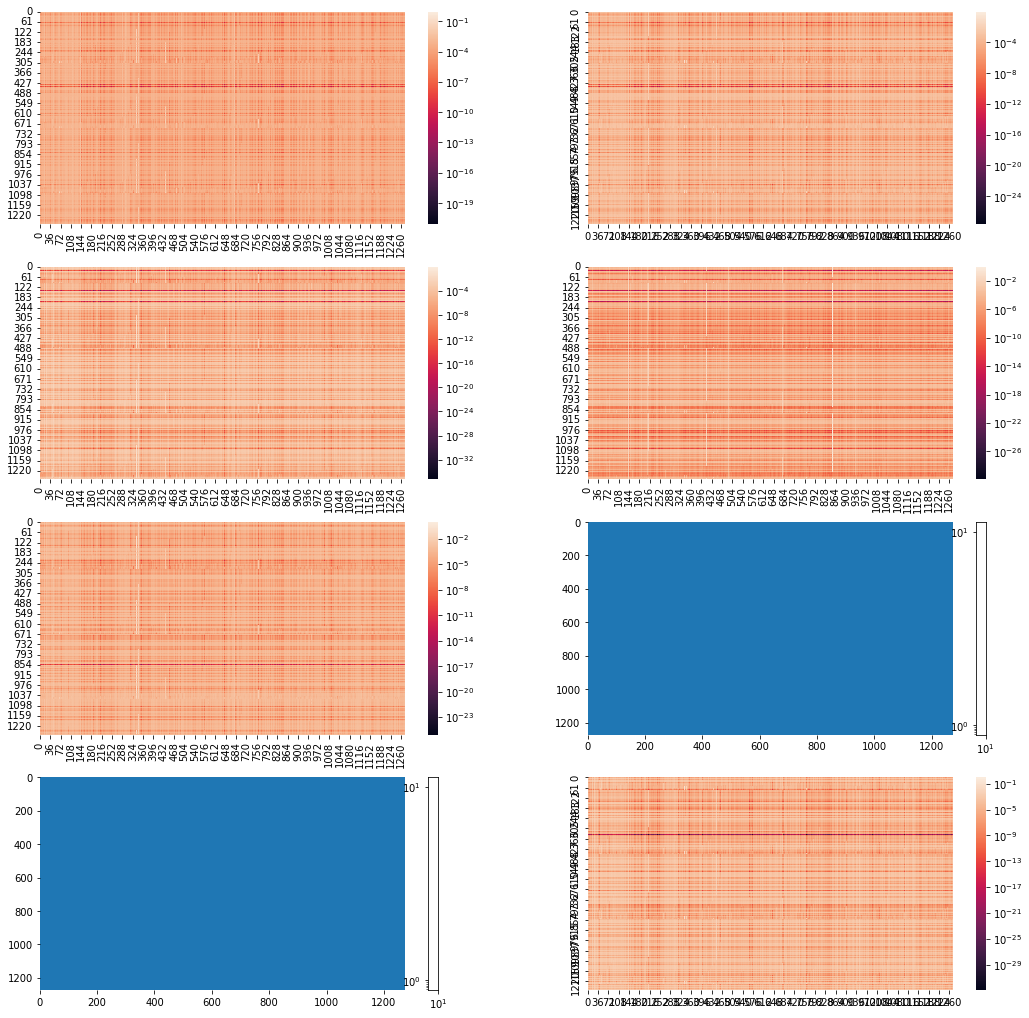

In [ ]:
k = 0

norm = {}
for m in range(8):
    norm[m] = LogNorm(vmin=np.min(np.min(wts[k,m])), vmax=np.max(np.max(wts[k,m])))

fig,ax = plt.subplots(4,2)
fig = fig.set_size_inches(18,18)
a = [ax[0,0], ax[1,0], ax[2,0], ax[3,0],
     ax[0,1], ax[1,1], ax[2,1], ax[3,1]]
for m in range(8):
    try:
        sns.heatmap(wts[k,m], ax = a[m], norm = norm[m])
    except:
        pass
# sns.heatmap(wts[k,0]/np.median(np.median(wts[k,0])), ax=ax[0,0])
# sns.heatmap(wts[k,1]/np.median(np.median(wts[k,1])), ax=ax[1,0])
# sns.heatmap(wts[k,2]/np.median(np.median(wts[k,2])), ax=ax[2,0])
# sns.heatmap(wts[k,3]/np.median(np.median(wts[k,3])), ax=ax[3,0])
# sns.heatmap(wts[k,4]/np.median(np.median(wts[k,4])), ax=ax[0,1])
# sns.heatmap(wts[k,5]/np.median(np.median(wts[k,5])), ax=ax[1,1])
# sns.heatmap(wts[k,6]/np.median(np.median(wts[k,6])), ax=ax[2,1])
# sns.heatmap(wts[k,7]/np.median(np.median(wts[k,7])), ax=ax[3,1])

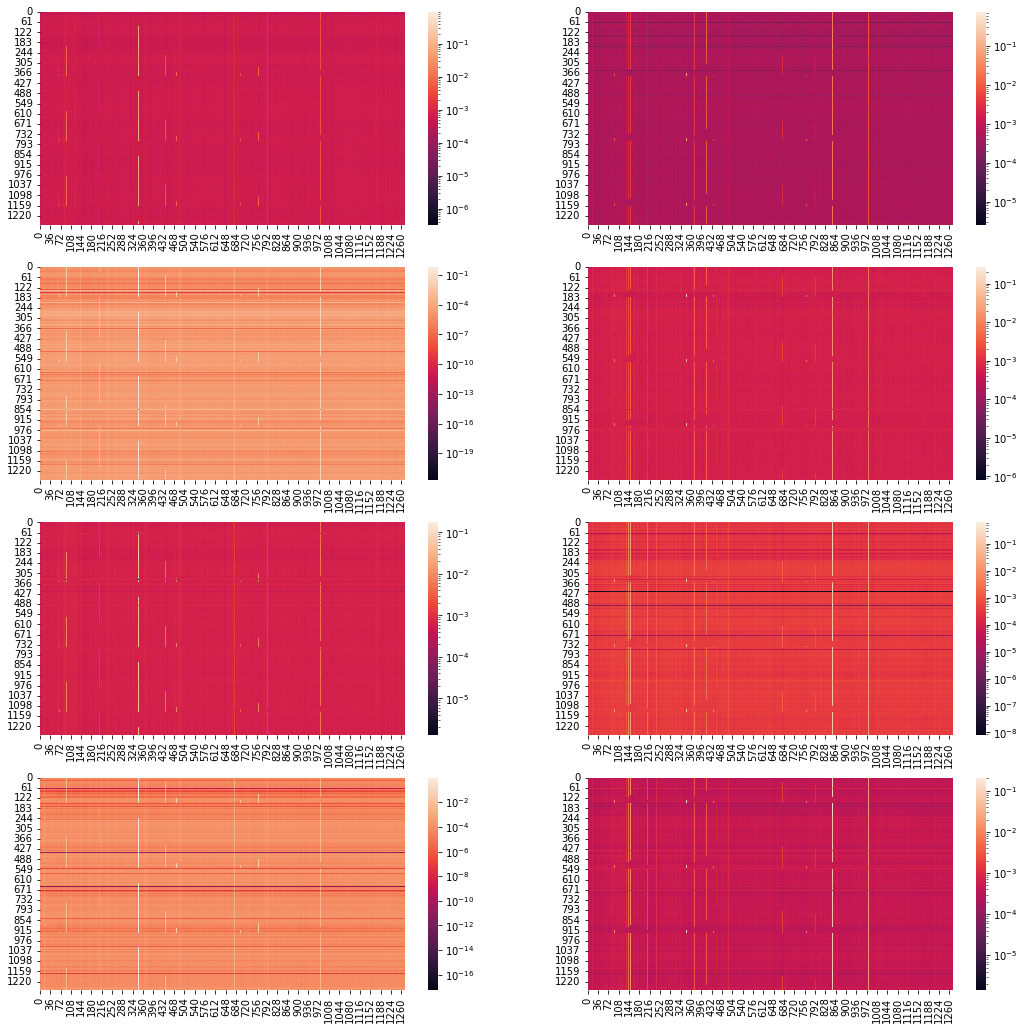

In [ ]:
k = 0

norm = {}
for m in range(8):
    norm[m] = LogNorm(vmin=np.min(np.min(wts[k,m])), vmax=np.max(np.max(wts[k,m])))

fig,ax = plt.subplots(4,2)
fig = fig.set_size_inches(18,18)
a = [ax[0,0], ax[1,0], ax[2,0], ax[3,0],
     ax[0,1], ax[1,1], ax[2,1], ax[3,1]]
for m in range(8):
    sns.heatmap(wts[k,m], ax = a[m], norm = norm[m])

# sns.heatmap(wts[k,0]/np.median(np.median(wts[k,0])), ax=ax[0,0])
# sns.heatmap(wts[k,1]/np.median(np.median(wts[k,1])), ax=ax[1,0])
# sns.heatmap(wts[k,2]/np.median(np.median(wts[k,2])), ax=ax[2,0])
# sns.heatmap(wts[k,3]/np.median(np.median(wts[k,3])), ax=ax[3,0])
# sns.heatmap(wts[k,4]/np.median(np.median(wts[k,4])), ax=ax[0,1])
# sns.heatmap(wts[k,5]/np.median(np.median(wts[k,5])), ax=ax[1,1])
# sns.heatmap(wts[k,6]/np.median(np.median(wts[k,6])), ax=ax[2,1])
# sns.heatmap(wts[k,7]/np.median(np.median(wts[k,7])), ax=ax[3,1])

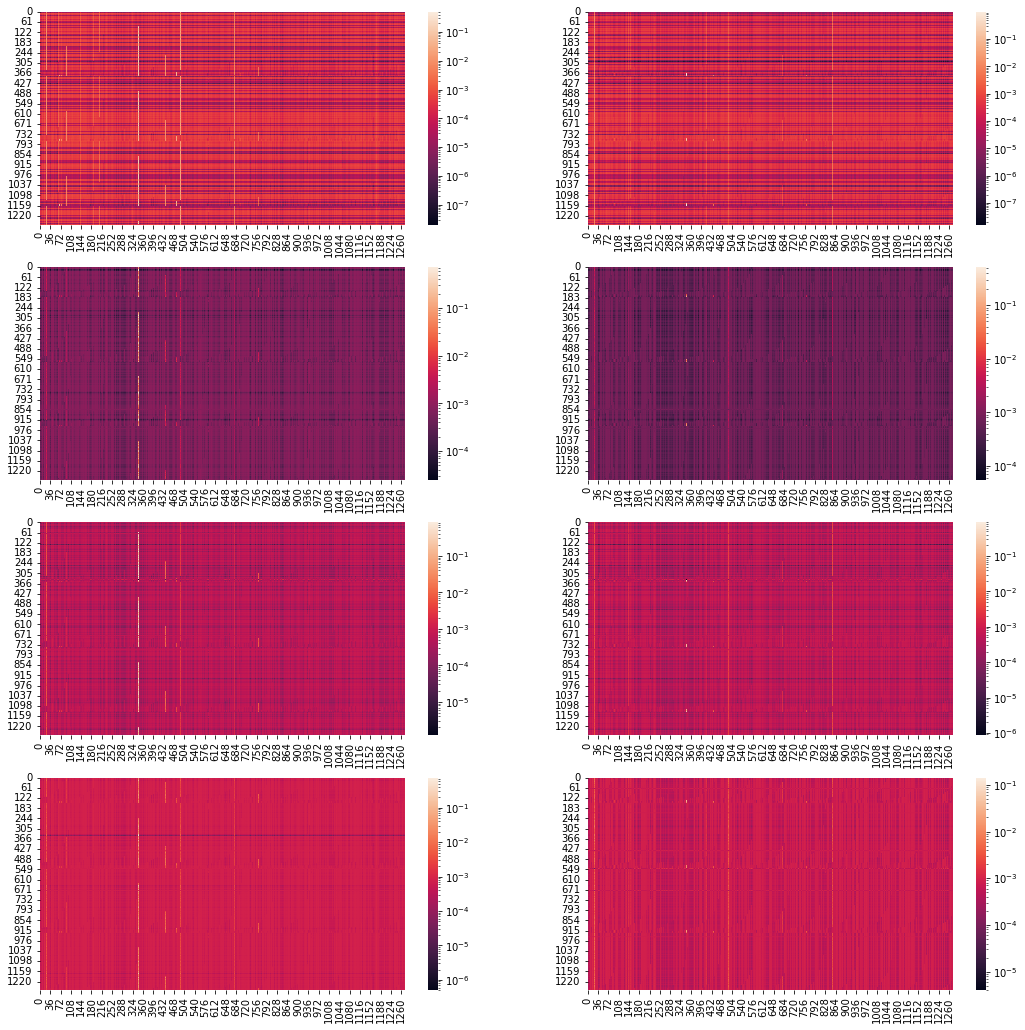

In [ ]:
k = 0

norm = {}
for m in range(8):
    norm[m] = LogNorm(vmin=np.min(np.min(wts[k,m])), vmax=np.max(np.max(wts[k,m])))

fig,ax = plt.subplots(4,2)
fig = fig.set_size_inches(18,18)
a = [ax[0,0], ax[1,0], ax[2,0], ax[3,0],
     ax[0,1], ax[1,1], ax[2,1], ax[3,1]]
for m in range(8):
    sns.heatmap(wts[k,m], ax = a[m], norm = norm[m])

# sns.heatmap(wts[k,0]/np.median(np.median(wts[k,0])), ax=ax[0,0])
# sns.heatmap(wts[k,1]/np.median(np.median(wts[k,1])), ax=ax[1,0])
# sns.heatmap(wts[k,2]/np.median(np.median(wts[k,2])), ax=ax[2,0])
# sns.heatmap(wts[k,3]/np.median(np.median(wts[k,3])), ax=ax[3,0])
# sns.heatmap(wts[k,4]/np.median(np.median(wts[k,4])), ax=ax[0,1])
# sns.heatmap(wts[k,5]/np.median(np.median(wts[k,5])), ax=ax[1,1])
# sns.heatmap(wts[k,6]/np.median(np.median(wts[k,6])), ax=ax[2,1])
# sns.heatmap(wts[k,7]/np.median(np.median(wts[k,7])), ax=ax[3,1])

,Head 0,Head 1,Head 2,Head 3,Head 4,Head 5,Head 6,Head 7
0,0.511012,0.195565,0.353342,0.214674,0.319711,0.167860,0.078291,0.223370
1,0.495741,0.198562,0.342231,0.159990,0.330740,0.182409,0.065876,0.229687
2,0.476835,0.172318,0.317069,0.175793,0.289689,0.224816,0.055918,0.199989
3,0.264787,0.095932,0.184990,0.138764,0.165244,0.159000,0.062342,0.111258
4,0.451179,0.229915,0.373587,0.132712,0.310613,0.130157,0.061525,0.277737
...,...,...,...,...,...,...,...,...
1268,0.325485,0.141246,0.252504,0.111651,0.238608,0.156010,0.048570,0.154522
1269,0.447011,0.160692,0.324260,0.133030,0.291325,0.143111,0.058130,0.183316
1270,0.179994,0.046171,0.120763,0.067121,0.104210,0.151394,0.044131,0.052806
1271,0.913443,0.548273,0.648163,0.208462,0.661096,0.178125,0.070408,0.631405


In [ ]:
mha = {}
for h in range(8):
    mha[h] = np.sum(wts[0,h], axis=0)
mhadf = pd.DataFrame.from_dict({f'Head {h}':mha[h] for h in range(8)})
topdf = pd.DataFrame.from_dict({f'Head {h}':mhadf.sort_values(by=f'Head {h}', ascending=False).head(30).index for h in range(8)})
display(topdf)

,Head 0,Head 1,Head 2,Head 3,Head 4,Head 5,Head 6,Head 7
0,678,678,678,477,678,855,345,678
1,68,338,338,12,338,546,451,338
2,69,79,79,855,79,416,678,79
3,338,68,68,763,68,477,338,68
4,12,763,345,968,763,763,79,69
5,763,69,69,678,69,69,68,763
6,79,439,451,546,439,439,69,345
7,439,345,763,68,968,968,214,439
8,968,968,439,439,345,144,680,451
9,451,451,214,69,214,143,12,968


In [ ]:
mha = {}
for h in range(8):
    mha[h] = np.sum(wts[0,h], axis=0)
mhadf = pd.DataFrame.from_dict({f'Head {h}':mha[h] for h in range(8)})
topdf = pd.DataFrame.from_dict({f'Head {h}':mhadf.sort_values(by=f'Head {h}', ascending=False).head(20).index for h in range(8)})
display(topdf)

,Head 0,Head 1,Head 2,Head 3,Head 4,Head 5,Head 6,Head 7
0,546,345,546,546,546,546,69,546
1,855,546,855,855,855,69,210,69
2,654,855,654,500,69,855,439,855
3,94,763,94,654,678,500,144,500
4,416,477,500,678,439,210,678,439
5,763,968,763,69,500,68,546,678
6,968,678,678,439,763,439,68,68
7,345,654,968,763,654,678,500,210
8,500,439,69,94,345,654,143,144
9,678,500,68,68,68,144,151,654


##Plot Embeddings

Sample code to plot TSNE of embeddings

In [ ]:
from sklearn.manifold import TSNE
t = TSNE(n_components=2).fit_transform(emb)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)

genus = ['Alphacoronavirus', 'Betacoronavirus', 'Gammacoronavirus', 'Deltacoronavirus']
for genus_ind in np.unique(ytest):
    selind = np.where(ytest==genus_ind)[0]
    ax.scatter(t[selind,0], t[selind,1], marker='x', label=genus[genus_ind])
ax.scatter(t[len(ytest):,0], t[len(ytest):,1], marker='x', label='Omicron')

ax.legend(bbox_to_anchor=(1.0, 0.9),  framealpha=1.0)
plt.show()